# Data Preprocessing and Encoding



In [ ]:
### Download dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-12-01 10:39:20--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-12-01 10:39:20 (25.3 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
### Read Dataset
with open('input.txt','r',encoding='utf-8') as f:
  text = f.read()

print("Total number of characters : ",len(text))
print(text[:400])

Total number of characters :  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it 


In [ ]:
### Tokenize the input
#####################################################
# Tiktoken : OpenAI GPT Tokenizer
# Trained using BytePair Encoding (BPE)
#####################################################
!pip install -q tiktoken
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
tokenized_text = tokenizer.encode(text)
print("Total number of tokens : ",len(tokenized_text))
print("Vocab Size : ",tokenizer.n_vocab)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.8 MB/s eta 0:00:00
Total number of tokens :  338025
Vocab Size :  50257


# Data Preparation

In [ ]:
### Prepare Dataset
import torch
from torch.utils.data import Dataset,DataLoader
###########################################################################################
# PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.
# Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores
# the samples and their corresponding labels, and DataLoader wraps an iterable around the
# Dataset to enable easy access to the samples.   (FROM PYTORCH Documentation)
# Actual reason of using dataset and dataloader is to standarize and modularize dataset
# preparation and loading steps
##########################################################################################
class myDataset(Dataset):
  def __init__(self,text,tokenizer,context_length,stride):
     self.input = []
     self.target = []
     tokens = tokenizer.encode(text)
     for i in range(0,len(tokens)-context_length,stride):
       input_sequence = tokens[i:i+context_length]
       target_sequence = tokens[i+1:i+context_length+1]
       self.input.append(input_sequence)
       self.target.append(target_sequence)

  def __len__(self):
    return len(self.input)
  def __getitem__(self,idx):
    return torch.tensor(self.input[idx]),torch.tensor(self.target[idx])

#########################################################################################################
# drop_last (bool, optional)  : set to True to drop the last incomplete batch, if the dataset size
# is not divisible by the batch size. If False and the size of dataset is not divisible by the batch
# size, then the last batch will be smaller. (default: False)
##########################################################################################################
def create_dataloader(text,tokenizer,context_length,stride,batch_size):
  if stride == 0 or stride > context_length:
     stride = context_length
  dataset = myDataset(text,tokenizer,context_length,stride)
  dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=True)
  return dataloader


* Set stride equal to context length to get minimum steps per epoch during training

* But it is better to have two different input and target pair have some overlapping tokens. So for that set stride lesser than context length


In [ ]:
dataloader = create_dataloader(text,tokenizer,context_length=256,stride=100,batch_size=64)

# Get Single Batch from Dataset
data_iter = iter(dataloader)
x,y = next(data_iter)
print(x.shape)
print(y.shape)

total_steps_per_epoch = len(dataloader)
print("Total number of steps per epoch : ",total_steps_per_epoch)

torch.Size([64, 256])
torch.Size([64, 256])
Total number of steps per epoch :  52


* Small batch sizes require less memory during training but lead to more noisy model updates. Just like in regular deep learning, the batch size is a tradeoff and a hyperparameter to experiment with when training LLMs.

* So to keep larger batch size in less memory we do a trick inspired from Andrej Karpathy Code where gradient of all steps is accumulated but not updated until you reach the batch size

# Embeddings

* In transformer we add Positional Encoding with the Input Embedding and then feed the result vectors into Tranformer layers

* Again Iam taking help from pytroch. So pytorch already have embedding layer module

* Embeddings weights Dimension = vocab_size * d

* d is usually set between 786 to 2048 in LLM. Larger the language model , larger will be d

In [ ]:
### Token Embeddings
d = 1024
embedding_layer = torch.nn.Embedding(tokenizer.n_vocab,d)
token_embeddings = embedding_layer(x)
print(token_embeddings.shape)

torch.Size([64, 256, 1024])


There are two types of positional embeddings


*   Simple positional embedding (Used here)
*   Rotatory positional embedding (RoPE)

Rotary Position Embedding, or RoPE, is a type of position embedding which encodes absolute positional information with rotation matrix and naturally incorporates explicit relative position dependency in self-attention formulation. Notably, RoPE comes with valuable properties such as flexibility of being expand to any sequence lengths, decaying inter-token dependency with increasing relative distances, and capability of equipping the linear self-attention with relative position encoding.  (RoFormer: Enhanced Transformer with Rotary Position Embedding by
Jianlin Su, Yu Lu, Shengfeng Pan, Ahmed Murtadha, Bo Wen, Yunfeng Liu)

* Actually The advantage of using RoPE is that you can pre-train model on a large dataset using smaller context length to save the computational resources and make the training faster and later on you can increase the context length of your model to what ever length you want and then perform few steps of training to adapt the model according to the increased context length

* Pytroch also have module implemented for Rotatory Positional Embeddings, most of the work is done so we can simply use the module

In [ ]:
context_length = 256
### Positional Embeddings
import torch.nn as nn
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

  # This code is taken from https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch
pos_emb = PositionalEncoding(d,  context_length)     # d = 1024 , context_length = 256

In [ ]:
### Final Input Embedding = Token Emeddning +  Positional Embeddnigs
input_embeddings = pos_emb.forward(token_embeddings)
print(input_embeddings.shape)

torch.Size([64, 256, 1024])


Here Above we see that when we add token embedding(64,100,1024) and positional embeddings(100,1024) we get (64,100,1024)

So here the positional embeddings of size (100,1024) is added to all 64 matrices of size (100,1024)  in token embeddings

Learn more about pytorch broadcasting : https://pytorch.org/docs/stable/notes/broadcasting.html



---



If you are interested in using rotaryPositionalEmbeddings then you can check pytorch implementation of it here https://pytorch.org/torchtune/stable/generated/torchtune.modules.RotaryPositionalEmbeddings.html.

 Right now I am not using it in my model because I completely do not know how rotaryPositionalEmbeddings works. But its cool  how it can increase the context length of your model upto million



---



**So here is the visual representation of what we have done so far**
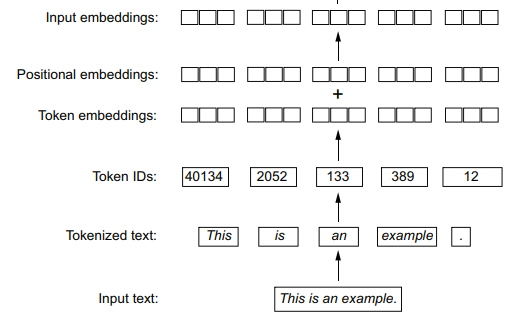

**Now its time to code the model architecture including the attention mechanism**

# Self-Attention Mechanism

**Basic intuiation of self-attention**


* We need a  vector that take care of the context of each word according to other words in the input
* A simple way that comes to mind is that we can take dot product of each token's input_embedding with all other input_embedding (as you remember until now we have embeddings of input tokens) so dot product of embeddings of two words or tokens give us the similarity between them
* So when we get dot product of each inputs with all input embeddings we will get a  vector of size equal to input size or specifically context length. Normalize this vector which I call as similarity vector
* Now we can simply take the weighted sum of inputs embedding using this normalized similarity vector



In [ ]:
input_embed = input_embeddings[:5]
input_embed.shape

torch.Size([5, 256, 1024])

In [ ]:
a = torch.randn(5, 10)
b = a.clone().detach()

a = a.T
b = torch.transpose(b,0,1)

a.shape, b.shape

(torch.Size([10, 5]), torch.Size([10, 5]))

In [ ]:
normalized_similarity_vector = torch.softmax(torch.matmul(input_embed,torch.transpose(input_embed,1,2)), dim=-1)
normalized_similarity_vector.shape

torch.Size([5, 256, 256])

In [ ]:
context_vector = torch.matmul(normalized_similarity_vector, input_embed)
context_vector.shape

torch.Size([5, 256, 1024])

In [ ]:
# If I implement above code usign key , query , value notation so key
# Finding context vector for 1st input vector with respect to all inputs

query1 = input_embed[0][0]       # input_emebed[0] act as query
keys = input_embed[0]           # keys are the input_embedding of all inputs
values = input_embed[0]         # values are alsoo input_embedding

attention_score1 = torch.matmul(query1,torch.transpose(keys,0,1))                  # attention score is similarity vector
attention_weight1 = torch.softmax(attention_score1, dim=-1)                       # attention weight is normalized similarity vector
context_vector1 = torch.matmul(attention_weight1, values)                         # context vector is weighted sum
print(context_vector1.shape)
# Here I have got context_vector for first input
# check if this context vector for second input is same as above calculated
torch.equal(context_vector1,context_vector[0][0])

torch.Size([1024])


True

So as we can see above input emebeddings vector act as query, keys and values what if we set query , key ,value trainable weights for each input and get 3 different vectors (Q,K,V) Query , Key , Value by mutliplying input_embedding with weights Wq , Wk , Wv

**Simple Attention**
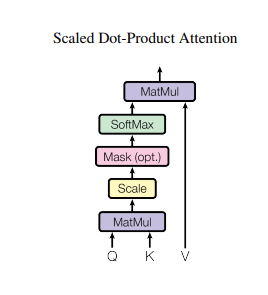

**As we can see above in the figure , to get context vector or scaled Dot-Product Attention vector  we first mutliply query with key then scale down the values by dividing with square root of attention vectors dimension and then apply softmax to normalize and finally matrix multiply it with values vector to get the attention vector or context vector**

In [ ]:
embed_size = input_embed.shape[-1]
attn_size = 512
Wq = torch.nn.Parameter(torch.rand(embed_size, attn_size))
Wk = torch.nn.Parameter(torch.rand(embed_size, attn_size))
Wv = torch.nn.Parameter(torch.rand(embed_size, attn_size))

In [ ]:
# Lets get query , key , value vectors for first input embedding
query1 = input_embed[0][0] @ Wq
key1 = input_embed[0][0] @ Wk
value1 = input_embed[0][0] @ Wv

In [ ]:
# Calculate context vector for first input embedding
keys = input_embed[0] @ Wk
values = input_embed[0] @ Wv
query1.shape , keys.shape , values.shape

(torch.Size([512]), torch.Size([256, 512]), torch.Size([256, 512]))

In [ ]:
attention_score1 = torch.matmul(query1,torch.transpose(keys,0,1))
d = keys.shape[-1]
attention_weight1 = torch.softmax(attention_score1/d**0.5, dim=-1)
context_vector1 = torch.matmul(attention_weight1, values)
context_vector1.shape

torch.Size([512])

In [ ]:
# Generalize for all input embeddings
queries = input_embed @ Wq
keys = input_embed @ Wk
values = input_embed @ Wv
queries.shape , keys.shape , values.shape

(torch.Size([5, 256, 512]),
 torch.Size([5, 256, 512]),
 torch.Size([5, 256, 512]))

In [ ]:
attn_scores = torch.matmul(queries, torch.transpose(keys, 1, 2))
print(attn_scores.shape)
d = keys.shape[-1]
attn_weights = torch.softmax(attn_scores/d**0.5, dim=-1)
print(attn_weights.shape)
attn_vector = torch.matmul(attn_weights, values)
print(attn_vector.shape)

torch.Size([5, 256, 256])
torch.Size([5, 256, 256])
torch.Size([5, 256, 512])


In [ ]:
print(f"Input (Embeddings) Dimensions = {input_embed.shape}")
print(f"Query Dimensions = {queries.shape}")
print(f"Key Dimensions = {keys.shape}")
print(f"Value Dimensions = {values.shape}")
print(f"Output (Attention Vector) Dimensions = {attn_vector.shape}")

Input (Embeddings) Dimensions = torch.Size([5, 256, 1024])
Query Dimensions = torch.Size([5, 256, 512])
Key Dimensions = torch.Size([5, 256, 512])
Value Dimensions = torch.Size([5, 256, 512])
Output (Attention Vector) Dimensions = torch.Size([5, 256, 512])


One thing to observe is that the dimensions can also be reduced using attention machanism

**Mask Future Tokens**

In [ ]:
x = torch.rand(3,3)
x

tensor([[0.6875, 0.0521, 0.1430],
        [0.8251, 0.3322, 0.6468],
        [0.9722, 0.0599, 0.1128]])

In [ ]:
mask = torch.triu(torch.ones(3,3),diagonal=1)
mask

tensor([[0., 1., 1.],
        [0., 0., 1.],
        [0., 0., 0.]])

In [ ]:
max_seq_length = 3
mask_bool = mask.bool()[:max_seq_length,:max_seq_length]
mask_bool

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]])

In [ ]:
x.masked_fill_(mask_bool,-torch.inf)

tensor([[0.6875,   -inf,   -inf],
        [0.8251, 0.3322,   -inf],
        [0.9722, 0.0599, 0.1128]])

In [ ]:
print(x)

tensor([[0.6875,   -inf,   -inf],
        [0.8251, 0.3322,   -inf],
        [0.9722, 0.0599, 0.1128]])


Next Step is **Multi-Head Attention**

Divide the embedding dimensions into n_head
If we have input embedding dimensions (Batch , Context_lenght , Embedding_Dimensions)

Divide Embedding_Dimensions into let suppose n_head = 4

So if we have inupt of dimensions (5 , 100, 1024) and 1024//4 = 256

We now have   4 heads with dimensions (5,100,256)

4 heads will run parallely and at end concatenate the 4 heads out to get original 1024 embedding

And finally pass it through Embeddings_Dimensions * Embedding_Dimensions layer




In [ ]:
embed_size = input_embed.shape[2]
n_heads = 4
din = embed_size
dout = embed_size
head_dim = dout//n_heads
Wk = nn.Linear(din, dout,bias=False)
Wv = nn.Linear(din, dout,bias=False)
Wq = nn.Linear(din, dout,bias=False)
mask = torch.triu(torch.ones(context_length,context_length),diagonal=1)

print("Emebd_size = ",embed_size)
print("Keys Weights = ",Wk.weight.shape)
print("Values Weights = ",Wv.weight.shape)
print("Queries Weights = ",Wq.weight.shape)
print("input_embeds = ",input_embed.shape)
print("Mask = ",mask.shape)

Emebd_size =  1024
Keys Weights =  torch.Size([1024, 1024])
Values Weights =  torch.Size([1024, 1024])
Queries Weights =  torch.Size([1024, 1024])
input_embeds =  torch.Size([5, 256, 1024])
Mask =  torch.Size([256, 256])


In [ ]:
keys = Wk(input_embed)    # Batch , Context_Length , Emebedding_Dimensions
values = Wv(input_embed)  # Batch , Context_Length , Emebedding_Dimensions
queries = Wq(input_embed) # Batch , Context_Length , Emebedding_Dimensions
keys.shape , values.shape , queries.shape

(torch.Size([5, 256, 1024]),
 torch.Size([5, 256, 1024]),
 torch.Size([5, 256, 1024]))

In [ ]:
Batch , Context_Len , Embed_Dim = keys.shape
keys = keys.view(Batch,Context_Len,n_heads,head_dim)       # Batch , Context_Length , num_heads , Head Dimensions
values = values.view(Batch,Context_Len,n_heads,head_dim)   # Batch , Context_Length , num_heads , Head Dimensions
queries = queries.view(Batch,Context_Len,n_heads,head_dim) # Batch , Context_Length , num_heads , Head Dimensions
print("Keys = ",keys.shape)
print("Values = ",values.shape)
print("Queries = ",queries.shape)

Keys =  torch.Size([5, 256, 4, 256])
Values =  torch.Size([5, 256, 4, 256])
Queries =  torch.Size([5, 256, 4, 256])


In [ ]:
keys = keys.transpose(1,2)
values = values.transpose(1,2)
queries = queries.transpose(1,2)
print("Keys = ",keys.shape)
print("Values = ",values.shape)
print("Queries = ",queries.shape)

Keys =  torch.Size([5, 4, 256, 256])
Values =  torch.Size([5, 4, 256, 256])
Queries =  torch.Size([5, 4, 256, 256])


Here we have 5 parallel batches , 4 parallel heads each containing matrix of 100 * 256

In [ ]:
attn_scores = queries @ keys.transpose(-1,-2)    # queries = 5, 4, 100 , 256  @ keys = 5,4,256,100
attn_scores.shape

torch.Size([5, 4, 256, 256])

Matrix A = 100 , 256

Martix B =       256 , 100

Matrix C  = Matrix A * Matrix B  (100,100)

Here 5 , 4 remains same for both Matrix A and Matrix B where 5 is batch size and 4 is heads size

In [ ]:
max_seq_len = context_length
mask_bool = mask.bool()[:max_seq_len,:max_seq_len]
attn_scores = attn_scores.masked_fill_(mask_bool, -torch.inf)
attn_scores.shape

torch.Size([5, 4, 256, 256])

In [ ]:
attn_weights = torch.softmax(
     attn_scores / keys.shape[-1]**0.5, dim=-1)

In [ ]:
context_vec = (attn_weights @ values).transpose(1, 2)

In [ ]:
context_vec = context_vec.contiguous().view(
 input_embed.shape)


In [ ]:
out_projection = nn.Linear(embed_size, embed_size)


In [ ]:
context_vec = out_projection(context_vec)

In [ ]:
print(context_vec.shape)

torch.Size([5, 256, 1024])


Lets structure the code into a class

In [ ]:
import torch
import torch.nn as nn
class MultiHeadAttention(nn.Module):
  def __init__(self,din,dout,context_length,n_heads):
    super().__init__()
    assert dout % n_heads == 0, "d_out must be divisible by n_heads"
    self.n_heads = n_heads
    self.head_dim = dout // n_heads
    self.Wk = nn.Linear(din, dout,bias=False)
    self.Wv = nn.Linear(din, dout,bias=False)
    self.Wq = nn.Linear(din, dout,bias=False)
    self.out_projection = nn.Linear(dout, dout)
    self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,input_embed):
    self.keys = self.Wk(input_embed)
    self.values = self.Wv(input_embed)
    self.queries = self.Wq(input_embed)

    batch , max_seq_len , embed_dim = input_embed.shape
    self.keys = self.keys.view(batch,max_seq_len,self.n_heads,self.head_dim)
    self.values = self.values.view(batch,max_seq_len,self.n_heads,self.head_dim)
    self.queries = self.queries.view(batch,max_seq_len,self.n_heads,self.head_dim)

    self.keys = self.keys.transpose(1,2)
    self.values = self.values.transpose(1,2)
    self.queries = self.queries.transpose(1,2)

    attn_scores = self.queries @ self.keys.transpose(-1,-2)
    bool_mask = self.mask.bool()[:max_seq_len,:max_seq_len]
    attn_scores.masked_fill_(bool_mask, -torch.inf)
    attn_weights = torch.softmax(
     attn_scores / self.keys.shape[-1]**0.5, dim=-1)
    context_vec = (attn_weights @ self.values).transpose(1, 2)
    context_vec = context_vec.reshape(batch, max_seq_len, self.dout)
    context_vec = self.out_projection(context_vec)

    return context_vec


# Layer Normalization

**Why and where we do Layer Normalization ?**

When we have a deep neural network with many layers it will have problem of vanishnig gradient or exploding gradient. So that is why we can apply normalization

Again what is vanishing gradient and exploding gradient so as we know while training there are a lot of matrix multiplications of floating point numbers
and these numbers could of random range and values , it is possible that some numbers became so large or became so small so we dont want that if the numbers became so small then it is vanishing gradient problem and if the number gets too large then it is exploding gradient problem.So in order to solve this problem we apply normalization means get the numberes in range of 0 to 1


In [ ]:
# let suppose we have a weight row with values 1.23, 4.34, 0.001 , 23.34
weight_row = [1.23,4.34,0.0001,23.24]

# Simplest way to normalize is to take sum of the weight matrix row and divide each element of that row with the sum
sum = sum(i for i in weight_row)
normalized_weight_row = [i/sum for i in weight_row]
print(normalized_weight_row)   # output = [0.04269336100881288, 0.15064161526686823, 3.471004960066088e-06, 0.8066615527193588]

# here we got all the numbers between range of 0 to 1 here we have solved the problem of exploding gradient by scaling down the large values
# but the small values got smaller and it will cause vanishing gradient problem so we need some other normailzation technique



[0.04269336100881288, 0.15064161526686823, 3.471004960066088e-06, 0.8066615527193588]


If you want to get into detail of layer normalization used here you can refer to these papers
[Batch Normalization](https://arxiv.org/abs/1502.03167) ,
[Layer Normalization](https://arxiv.org/abs/1607.06450)


In [ ]:
# apply layer normalization before multihead attention and feed foward network
norm = torch.nn.LayerNorm(input_embed.shape)
x = norm(input_embed)
print(input_embed.shape,x.shape)

torch.Size([5, 256, 1024]) torch.Size([5, 256, 1024])


### Feed Forward

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

class FeedForward(nn.Module):
  def __init__(self, config):
      super().__init__()
      self.layers = nn.Sequential(
      nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
      GELU(),
      nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
      )
  def forward(self, x):
    return self.layers(x)

# Decoder Block

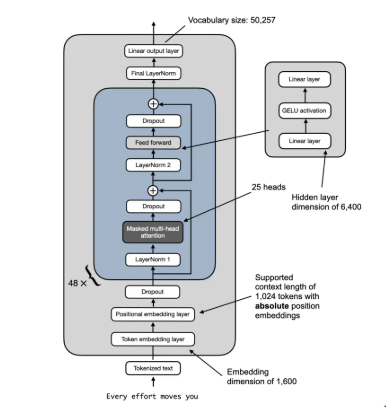

**In decoder block first we have layernorm1 then multihead attention then drop then residual addition (shortcut connection) then layernorm2 , feed forward network , dropout and at last again a shortcut connection. Maybe I'll add an image of the architecture if I found one**

In [ ]:
class Decoder(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.attention = MultiHeadAttention(
        din = config['embedding_dim'],
        dout = config['embedding_dim'],
        context_length = config['context_length'],
        n_heads = config['n_heads'] )
    self.forward = FeedForward(config)
    self.layernorm1 = nn.LayerNorm(config['embedding_dim'])
    self.layernorm2 = nn.LayerNorm(config['embedding_dim'])
    self.dropout = nn.Dropout(config['dropout'])

  def forward(self,x):
     resdiual_connection = x
     x = self.layernorm1(x)
     x = self.attention(x)
     x = self.dropout(x)
     x = x + resdiual_connection

     resdiual_connection = x
     x = self.layernorm2(x)
     x = self.forward(x)
     x = self.dropout(x)
     x = x + resdiual_connection
     return x


**Now lets connect the building blocks to create a final SLM Class**

In [ ]:
class SLM(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = nn.Embedding(config['vocab_size'],config['embedding_dim'])
    self.position_embedding = PositionalEncoding(config['embedding_dim'],config['context_length'])
    self.emebedding_dropout = nn.Dropout(config['dropout'])
    self.decoder_blocks =  nn.Sequential(*[Decoder(config) for _ in range(config['n_layers'])])
    self.final_layernorm = nn.LayerNorm(config['embedding_dim'])
    self.output_layer = nn.Linear(config['embedding_dim'],config['vocab_size'],bias=False)

  def forward(self,x):
    x = self.embedding(x)
    x = self.position_embedding(x)
    x = self.emebedding_dropout(x)

    x = self.decoder_blocks(x)
    x = self.final_layernorm(x)

    logits = self.output_layer(x)
    return logits


# Text Generation

In [ ]:
@torch.no_grad()
def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

# This function code is taken from Andrej Karpathy Github https://github.com/karpathy/nanoGPT/blob/master/model.py

In [ ]:
# A modified version of above function
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

# Complete Pre-training Code

In [ ]:
import torch


Device = cuda


In [ ]:
!pip -q install tiktoken
!pip -q install torch
!pip -q install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.3 MB/s eta 0:00:00


Total Training Steps  = 80
Ep 1 (Step 000000): Train loss 9.630, Val loss 9.914
Total Epoch Time : 6.28584885597229
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the, the, the the the the the, the the the the, the
Total Epoch Time : 4.883731126785278
Every effort moves you.                                                 
Total Epoch Time : 5.004505157470703
Every effort moves you.                                                 
Total Epoch Time : 4.9475109577178955
Every effort moves you.                                                 
Total Epoch Time : 5.021944999694824
Every effort moves you.                                                 
Total Epoch Time : 5.033508539199829
Every effort moves you.                                                 
Total Epoch Time : 5.0793070793151855
Every effort moves you.                                                 
Total Epoch

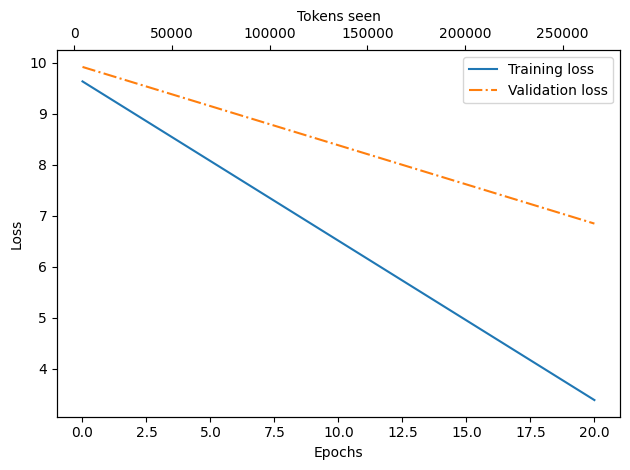

In [ ]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch

import time
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import math
import matplotlib.pyplot as plt
import os
import urllib.request

tpu_flag = False
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  import torch_xla.distributed.parallel_loader as pl
  import torch_xla.utils.serialization as xser
except ModuleNotFoundError:
  pass
else:
  tpu_flag = True
  print("TPU detected")
  print(f"TPU Devices Available : {torch_xla.device_count()}")

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    # loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    peak_lr = optimizer.param_groups[0]["lr"]
    min_lr = 0.1 * peak_lr
    total_training_steps = len(train_loader) * num_epochs
    warmup_steps = 0.1 * total_training_steps
    print(f"Total Training Steps  = {total_training_steps}")
    if tpu_flag:
      train_loader = pl.MpDeviceLoader(train_loader, device)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        start = time.time()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            global_step += 1
            if global_step < warmup_steps:
                lr = peak_lr * (global_step+1)/warmup_steps
            else:
                progress = ((global_step - warmup_steps) /(total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients

            if global_step > warmup_steps:
                  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            if tpu_flag:
              xm.optimizer_step(optimizer)
            else:
              optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()


            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # print(f"Time Taken = {time.time()-start}")
                # start = time.time()
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")


        end = time.time()
        print(f"Total Epoch Time : {end-start}")

        # Print a sample text after each epoch
        if tpu_flag:
          if torch_xla.core.xla_model.is_master_ordinal():
              generate_and_print_sample(
                  model, tokenizer, device, start_context
              )
        else:
          generate_and_print_sample(
              model, tokenizer, device, start_context
          )

    return train_losses, val_losses, track_tokens_seen


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.show()


def main(gpt_config, settings):
    device = None
    if tpu_flag:
      xm.set_rng_state(123, device=device)
      device = xm.xla_device()
    else:
       torch.manual_seed(123)
       device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    ##############################
    # Download data if necessary
    ##############################

    file_path = "AllCombined.txt"
    # url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    # if not os.path.exists(file_path):
    #     with urllib.request.urlopen(url) as response:
    #         text_data = response.read().decode('utf-8')
    #     with open(file_path, "w", encoding="utf-8") as file:
    #         file.write(text_data)
    # else:
    with open(file_path, "r", encoding="utf-8") as file:
          data = file.read()
    text_data = data[:100000]
    ##############################
    # Initialize model
    ##############################

    model = GPTModel(gpt_config)
    model.to(device)  # no assignment model = model.to(device) necessary for nn.Module classes
    if tpu_flag:
      model = torch.compile(model)
    else:
      model = torch.compile(model)

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

    ##############################
    # Set up dataloaders
    ##############################

    # Train/validation ratio
    train_ratio = 0.90
    split_idx = int(train_ratio * len(text_data))

    train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    ##############################
    # Train model
    ##############################

    tokenizer = tiktoken.get_encoding("gpt2")
    start = time.time()
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=64, eval_iter=1,
        start_context="Every effort moves you", tokenizer=tokenizer
    )
    end = time.time()
    print(f"Total training time: {end - start:.2f} seconds")

    epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    plt.savefig("loss.pdf")

    # Save and load model
    if tpu_flag:
      xser.save(model.state_dict(), "model.pth")
    else:
      torch.save(model.state_dict(), "model.pth")


if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50264,    # Vocabulary size
        "context_length": 256,  # Shortened context length (orig: 1024)
        "emb_dim": 768,         # Embedding dimension
        "n_heads": 16,          # Number of attention heads
        "n_layers": 16,         # Number of layers
        "drop_rate": 0.1,       # Dropout rate
        "qkv_bias": False       # Query-key-value bias
    }

    OTHER_SETTINGS = {
        "learning_rate": 3e-4,
        "num_epochs": 20,
        "batch_size": 16,
        "weight_decay": 0.1
    }

    ###########################
    # Initiate training
    ###########################
   if tpu_flag:
     torch_xla.launch(_mp_fn, args=())
   else:
     main(GPT_CONFIG_124M, OTHER_SETTINGS)


Device = cuda
Total Training Steps  = 80
Ep 1 (Step 000000): Train loss 9.630, Val loss 9.914
Total Epoch Time : 6.494552373886108
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the, the, the the the the the, the the the the, the
Total Epoch Time : 5.074737787246704
Every effort moves you.                                                 
Total Epoch Time : 5.256582021713257
Every effort moves you.                                                 
Total Epoch Time : 5.235011339187622
Every effort moves you.                                                 
Total Epoch Time : 5.261898756027222
Every effort moves you.                                                 
Total Epoch Time : 5.267335414886475
Every effort moves you.                                                 
Total Epoch Time : 5.208603620529175
Every effort moves you.                                                

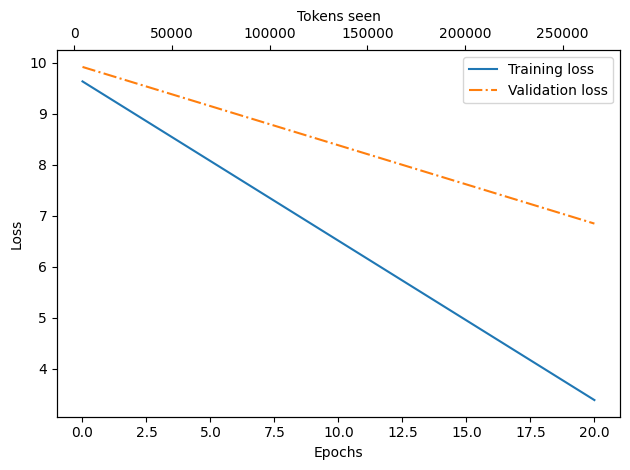

In [ ]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch

import time
import tiktoken
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import math
import matplotlib.pyplot as plt
import os
import urllib.request

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
  import torch_xla
  import torch_xla.core.xla_model as xm
  import torch_xla.distributed.parallel_loader as pl
  import torch_xla.distributed.xla_multiprocessing as xmp
except ModuleNotFoundError:
  print(f"Device = {device}")
else:
  device = xm.xla_device()
  print("TPU detected")
  print(f"TPU Devices Available : {torch_xla.device_count()}")

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    # loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), target_batch.view(-1))
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Main training loop
    peak_lr = optimizer.param_groups[0]["lr"]
    min_lr = 0.1 * peak_lr
    total_training_steps = len(train_loader) * num_epochs
    warmup_steps = 0.1 * total_training_steps
    print(f"Total Training Steps  = {total_training_steps}")
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        start = time.time()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            global_step += 1
            if global_step < warmup_steps:
                lr = peak_lr * (global_step+1)/warmup_steps
            else:
                progress = ((global_step - warmup_steps) /(total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients

            if global_step > warmup_steps:
                  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()


            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                # print(f"Time Taken = {time.time()-start}")
                # start = time.time()
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")


        end = time.time()
        print(f"Total Epoch Time : {end-start}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots()

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    # plt.show()


def main(gpt_config, settings):
    torch.manual_seed(123)

    ##############################
    # Download data if necessary
    ##############################

    file_path = "AllCombined.txt"
    # url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    # if not os.path.exists(file_path):
    #     with urllib.request.urlopen(url) as response:
    #         text_data = response.read().decode('utf-8')
    #     with open(file_path, "w", encoding="utf-8") as file:
    #         file.write(text_data)
    # else:
    with open(file_path, "r", encoding="utf-8") as file:
          data = file.read()
    text_data = data[:100000]
    ##############################
    # Initialize model
    ##############################

    model = GPTModel(gpt_config)
    model.to(device)  # no assignment model = model.to(device) necessary for nn.Module classes
    # model = torch.compile(model)
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

    ##############################
    # Set up dataloaders
    ##############################

    # Train/validation ratio
    train_ratio = 0.90
    split_idx = int(train_ratio * len(text_data))

    train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    ##############################
    # Train model
    ##############################

    tokenizer = tiktoken.get_encoding("gpt2")
    start = time.time()
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=64, eval_iter=1,
        start_context="Every effort moves you", tokenizer=tokenizer
    )
    end = time.time()
    print(f"Total training time: {end - start:.2f} seconds")
    return train_losses, val_losses, tokens_seen, model


if __name__ == "__main__":

    GPT_CONFIG_124M = {
        "vocab_size": 50264,    # Vocabulary size
        "context_length": 256,  # Shortened context length (orig: 1024)
        "emb_dim": 768,         # Embedding dimension
        "n_heads": 16,          # Number of attention heads
        "n_layers": 16,         # Number of layers
        "drop_rate": 0.1,       # Dropout rate
        "qkv_bias": False       # Query-key-value bias
    }

    OTHER_SETTINGS = {
        "learning_rate": 3e-4,
        "num_epochs": 20,
        "batch_size": 16,
        "weight_decay": 0.1
    }

    ###########################
    # Initiate training
    ###########################

    train_losses, val_losses, tokens_seen, model = main(GPT_CONFIG_124M, OTHER_SETTINGS)

    ###########################
    # After training
    ###########################

    # Plot results
    epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    plt.savefig("loss.pdf")

    # Save and load model
    torch.save(model.state_dict(), "model.pth")
    # model = GPTModel(GPT_CONFIG_124M)
    # model.load_state_dict(torch.load("model.pth"), weights_only=True)

# Waste

In [ ]:
# class myDataset(Dataset):
#   def __init__(self,text,tokenizer,context_length,stride):
#      self.input = []
#      self.target = []
#      tokens = tokenizer.encode(text)
#      for i in range(0,len(tokens)-context_length,stride):
#        input_sequence = tokens[i:i+context_length]
#        target_sequence = tokens[i+1:i+context_length+1]
#        self.input.append(input_sequence)
#        self.target.append(target_sequence)

#   def __len__(self):
#     return len(self.input)
#   def __getitem__(self,idx):
#     return torch.tensor(self.input[idx]),torch.tensor(self.target[idx])

# def create_dataloader(text, tokenizer, batch_size=4, context_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
#   if stride == 0 or stride > context_length:
#      stride = context_length
#   dataset = myDataset(text,tokenizer,context_length,stride)
#   dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
#   return dataloader


# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super(PositionalEncoding, self).__init__()

#         pe = torch.zeros(max_seq_length, d_model)
#         position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)

#         self.register_buffer('pe', pe.unsqueeze(0))

#     def forward(self, x):
#         return x + self.pe[:, :x.size(1)]


# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
#         super().__init__()
#         assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

#         self.d_out = d_out
#         self.num_heads = num_heads
#         self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

#         self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
#         self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
#         self.dropout = nn.Dropout(dropout)
#         self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

#     def forward(self, x):
#         b, num_tokens, d_in = x.shape

#         keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
#         queries = self.W_query(x)
#         values = self.W_value(x)

#         # We implicitly split the matrix by adding a `num_heads` dimension
#         # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
#         keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
#         values = values.view(b, num_tokens, self.num_heads, self.head_dim)
#         queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

#         # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
#         keys = keys.transpose(1, 2)
#         queries = queries.transpose(1, 2)
#         values = values.transpose(1, 2)

#         # Compute scaled dot-product attention (aka self-attention) with a causal mask
#         attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

#         # Original mask truncated to the number of tokens and converted to boolean
#         mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

#         # Use the mask to fill attention scores
#         attn_scores.masked_fill_(mask_bool, -torch.inf)

#         attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
#         attn_weights = self.dropout(attn_weights)

#         # Shape: (b, num_tokens, num_heads, head_dim)
#         context_vec = (attn_weights @ values).transpose(1, 2)

#         # Combine heads, where self.d_out = self.num_heads * self.head_dim
#         context_vec = context_vec.reshape(b, num_tokens, self.d_out)
#         context_vec = self.out_proj(context_vec)  # optional projection

#         return context_vec

# class GELU(nn.Module):
#   def __init__(self):
#     super().__init__()
#   def forward(self, x):
#     return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

# class FeedForward(nn.Module):
#   def __init__(self, config):
#       super().__init__()
#       self.layers = nn.Sequential(
#       nn.Linear(config["embedding_dim"], 4 * config["embedding_dim"]),
#       GELU(),
#       nn.Linear(4 * config["embedding_dim"], config["embedding_dim"]),
#       )
#   def forward(self, x):
#     return self.layers(x)


# class Decoder(nn.Module):
#   def __init__(self,config):
#     super().__init__()
#     self.attention = MultiHeadAttention(
#         din = config['embedding_dim'],
#         dout = config['embedding_dim'],
#         context_length = config['context_length'],
#         n_heads = config['n_heads'] )
#     self.forward = FeedForward(config)
#     self.layernorm1 = nn.LayerNorm(config['embedding_dim'])
#     self.layernorm2 = nn.LayerNorm(config['embedding_dim'])
#     self.dropout = nn.Dropout(config['dropout'])

#   def forward(self,x):
#      resdiual_connection = x
#      x = self.layernorm1(x)
#      x = self.attention(x)
#      x = self.dropout(x)
#      x = x + resdiual_connection

#      resdiual_connection = x
#      x = self.layernorm2(x)
#      x = self.forward(x)
#      x = self.dropout(x)
#      x = x + resdiual_connection
#      return x


# class SLM(nn.Module):
#   def __init__(self,config):
#     super().__init__()
#     self.embedding = nn.Embedding(config['vocab_size'],config['embedding_dim'])
#     self.position_embedding = PositionalEncoding(config['embedding_dim'],config['context_length'])
#     self.emebedding_dropout = nn.Dropout(config['dropout'])
#     self.decoder_blocks =  nn.Sequential(*[Decoder(config) for _ in range(config['n_layers'])])
#     self.final_layernorm = nn.LayerNorm(config['embedding_dim'])
#     self.output_layer = nn.Linear(config['embedding_dim'],config['vocab_size'],bias=False)

#   def forward(self,x):
#     x = self.embedding(x)
#     x = self.position_embedding(x)
#     x = self.emebedding_dropout(x)

#     x = self.decoder_blocks(x)
#     x = self.final_layernorm(x)

#     logits = self.output_layer(x)
#     return logits

# def generate_text(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

#     # For-loop is the same as before: Get logits, and only focus on last time step
#     for _ in range(max_new_tokens):
#         idx_cond = idx[:, -context_size:]
#         with torch.no_grad():
#             logits = model(idx_cond)
#         logits = logits[:, -1, :]

#         # New: Filter logits with top_k sampling
#         if top_k is not None:
#             # Keep only top_k values
#             top_logits, _ = torch.topk(logits, top_k)
#             min_val = top_logits[:, -1]
#             logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

#         # New: Apply temperature scaling
#         if temperature > 0.0:
#             logits = logits / temperature

#             # Apply softmax to get probabilities
#             probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

#             # Sample from the distribution
#             idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

#         # Otherwise same as before: get idx of the vocab entry with the highest logits value
#         else:
#             idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

#         if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
#             break

#         # Same as before: append sampled index to the running sequence
#         idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

#     return idx


# def text_to_token_ids(text, tokenizer):
#     encoded = tokenizer.encode(text)
#     encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
#     return encoded_tensor

# def token_ids_to_text(token_ids, tokenizer):
#     flat = token_ids.squeeze(0)  # remove batch dimension
#     return tokenizer.decode(flat.tolist())

# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#     logits = model(input_batch)
#     loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
#     return loss


# def calc_loss_loader(data_loader, model, device, num_batches=None):
#     total_loss = 0.
#     if len(data_loader) == 0:
#         return float("nan")
#     elif num_batches is None:
#         num_batches = len(data_loader)
#     else:
#         num_batches = min(num_batches, len(data_loader))
#     for i, (input_batch, target_batch) in enumerate(data_loader):
#         if i < num_batches:
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             total_loss += loss.item()
#         else:
#             break
#     return total_loss / num_batches


# def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#     model.eval()
#     with torch.no_grad():
#         train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
#         val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
#     model.train()
#     return train_loss, val_loss


# def generate_and_print_sample(model, tokenizer, device, start_context,context_size):
#     model.eval()
#     encoded = text_to_token_ids(start_context, tokenizer).to(device)
#     with torch.no_grad():
#         token_ids = generate_text(
#             model=model, idx=encoded,
#             max_new_tokens=50, context_size=context_size
#         )
#         decoded_text = token_ids_to_text(token_ids, tokenizer)
#         print(decoded_text.replace("\n", " "))  # Compact print format
#     model.train()


# def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
#                        eval_freq, eval_iter, start_context, tokenizer,context_length):
#     # Initialize lists to track losses and tokens seen
#     train_losses, val_losses, track_tokens_seen = [], [], []
#     tokens_seen = 0
#     global_step = -1

#     # Main training loop
#     for epoch in range(num_epochs):
#         model.train()  # Set model to training mode

#         for input_batch, target_batch in train_loader:
#             optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward()  # Calculate loss gradients
#             optimizer.step()  # Update model weights using loss gradients
#             xm.optimizer_step(optimizer)
#             tokens_seen += input_batch.numel()
#             global_step += 1

#             # Optional evaluation step
#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(
#                     model, train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(tokens_seen)
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): "
#                       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

#         # Print a sample text after each epoch
#         generate_and_print_sample(
#             model, tokenizer, device, start_context,context_length
#         )

#     return train_losses, val_losses, track_tokens_seen


# def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
#     fig, ax1 = plt.subplots()

#     # Plot training and validation loss against epochs
#     ax1.plot(epochs_seen, train_losses, label="Training loss")
#     ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
#     ax1.set_xlabel("Epochs")
#     ax1.set_ylabel("Loss")
#     ax1.legend(loc="upper right")

#     # Create a second x-axis for tokens seen
#     ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
#     ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
#     ax2.set_xlabel("Tokens seen")

#     fig.tight_layout()  # Adjust layout to make room
#     # plt.show()

# def main(gpt_config, settings):

#     torch.manual_seed(123)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#     ###############################
#     # Load Tokenizer
#     ###############################

#     tokenizer = tiktoken.get_encoding("gpt2")


#     ##############################
#     # Download data if necessary
#     ##############################

#     file_path = "the-verdict.txt"
#     url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

#     if not os.path.exists(file_path):
#         with urllib.request.urlopen(url) as response:
#             text_data = response.read().decode('utf-8')
#         with open(file_path, "w", encoding="utf-8") as file:
#             file.write(text_data)
#     else:
#         with open(file_path, "r", encoding="utf-8") as file:
#             text_data = file.read()

#     ##############################
#     # Initialize model
#     ##############################

#     model = SLM(gpt_config)
#     model.to(device)  # no assignment model = model.to(device) necessary for nn.Module classes
#     optimizer = torch.optim.AdamW(
#         model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
#     )

#     ##############################
#     # Set up dataloaders
#     ##############################

#     # Train/validation ratio
#     train_ratio = 0.90
#     split_idx = int(train_ratio * len(text_data))

#     train_loader = create_dataloader(
#         text_data[:split_idx],
#         tokenizer = tokenizer,
#         batch_size=settings["batch_size"],
#         context_length=gpt_config["context_length"],
#         stride=gpt_config["context_length"],
#         shuffle=True,
#         drop_last=True,
#         num_workers=0
#     )

#     val_loader = create_dataloader(
#         text_data[split_idx:],
#         tokenizer = tokenizer,
#         batch_size=settings["batch_size"],
#         context_length=gpt_config["context_length"],
#         stride=gpt_config["context_length"],
#         shuffle=False,
#         drop_last=False,
#         num_workers=0
#     )

#     ##############################
#     # Train model
#     ##############################



#     train_losses, val_losses, tokens_seen = train_model_simple(
#         model, train_loader, val_loader, optimizer, device,
#         num_epochs=settings["num_epochs"], eval_freq=5, eval_iter=1,
#         start_context="Every effort moves you", tokenizer=tokenizer,context_length=gpt_config["context_length"]
#     )

#     return train_losses, val_losses, tokens_seen, model


# if __name__ == "__main__":

#     GPT_CONFIG_124M = {
#         "vocab_size": 50257,    # Vocabulary size
#         "context_length": 256,  # Shortened context length (orig: 1024)
#         "embedding_dim": 768,   # Embedding dimension
#         "n_heads": 12,          # Number of attention heads
#         "n_layers": 12,         # Number of layers
#         "dropout": 0.1,         # Dropout rate
#         "qkv_bias": False       # Query-key-value bias
#     }

#     OTHER_SETTINGS = {
#         "learning_rate": 5e-4,
#         "num_epochs": 10,
#         "batch_size": 2,
#         "weight_decay": 0.1
#     }

#     ###########################
#     # Initiate training
#     ###########################

#     train_losses, val_losses, tokens_seen, model = main(GPT_CONFIG_124M, OTHER_SETTINGS)

#     ###########################
#     # After training
#     ###########################

#     # Plot results
#     epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
#     plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
#     plt.savefig("loss.pdf")

#     # Save and load model
#     torch.save(model.state_dict(), "model.pth")
#     model = SLM(GPT_CONFIG_124M)
#     model.load_state_dict(torch.load("model.pth"), weights_only=True)